<a href="https://colab.research.google.com/github/Mobisafrankline/wqu-MScFE/blob/master/Gwp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Financial Problem

Problem Statement:
The paper addresses the challenge of forecasting stock market movements in emerging markets, which are inherently more volatile, less liquid, and more sensitive to local and global shocks compared to developed markets. The primary difficulty lies in building robust predictive models in such noisy and inefficient environments.

Emerging vs. Developed Markets:
Emerging markets differ in several key ways:

Informational Inefficiency: Models can exploit inefficiencies that are already arbitraged in developed markets.

Data Challenges: Non-stationarity, lower quality data, and higher susceptibility to political and macroeconomic shocks.

Implications for Model Design:
To address these challenges, the study emphasizes:

Robust Feature Engineering: Selecting features that remain stable and informative despite market noise.

Sophisticated Optimization: Using techniques like Genetic Algorithms to fine-tune indicator parameters for better adaptation to emerging market dynamics.

Robust Validation: Employing k-fold cross-validation to reduce overfitting and ensure model generalization across volatile periods.

Step 2: Application

Main Takeaways from the Results:


*   The hybrid model (optimized technical indicators + neural network) outperformed traditional statistical methods and models using non-optimized indicators.
*   Feature selection (LASSO) and parameter optimization (Genetic Algorithm) were crucial in enhancing predictive accuracy.



* The model achieved accuracies well above 50%, indicating practical utility for trend-following trading strategies in emerging markets.


Most Useful Features:
Although the paper includes a broad set of indicators, LASSO likely highlighted the most predictive features. Typically, these include:

*   The model achieved accuracies well above 50%, indicating practical utility for trend-following trading strategies in emerging markets.  
*   Feature selection (LASSO) and parameter optimization (Genetic Algorithm) were crucial in enhancing predictive accuracy.





Trend-Following Indicators: e.g., MACD, which captures the underlying market trend.

*    Momentum Oscillators: e.g., RSI, which signals overbought or oversold conditions.

* Trend-Following Indicators: e.g., MACD, which captures the underlying market trend.




In [1]:
# ========================================
# COMPLETE END-TO-END REPLICATION PIPELINE
# ========================================

# Step 0: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = "{:,.6f}".format


In [14]:
import datetime

start = datetime.date(2009, 12, 12)
end = datetime.date(2020, 1, 1)

# Getting the daily prices for Chile ETF

tickers = ["ECH"]

df = yf.download(tickers, start=start, end=end, auto_adjust = False)
df.index = df.index.tz_localize('UTC')

# Flattening the MultiIndex DataFrame by joining level names
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

df = df[['Open_ECH', 'High_ECH', 'Low_ECH', 'Close_ECH', 'Volume_ECH']]

[*********************100%***********************]  1 of 1 completed


In [17]:
# Step 2: Feature Engineering - Technical Indicators
# --- Simple Moving Averages
df['SMA_10'] = df['Close_ECH'].rolling(10).mean()
df['SMA_20'] = df['Close_ECH'].rolling(20).mean()

# --- Exponential Moving Averages
df['EMA_10'] = df['Close_ECH'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close_ECH'].ewm(span=20, adjust=False).mean()

In [20]:
# --- Relative Strength Index (RSI)
delta = df['Close_ECH'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# --- Momentum (Close - Previous Close)
df['Momentum'] = df['Close_ECH'] - df['Close_ECH'].shift(1)

# --- Drop NaNs caused by rolling windows
df.dropna(inplace=True)

In [23]:
# Step 3: Target Variable - Up/Down based on next day's Close
df['Gamma'] = np.where(df['Close_ECH'].shift(-1) > df['Close_ECH'], 1, -1)
df.dropna(inplace=True)

# Step 4: Normalize Features (Min-Max Scaling)
features = df.drop(columns=['Gamma'])
target = df['Gamma']
features_norm = (features - features.min()) / (features.max() - features.min())

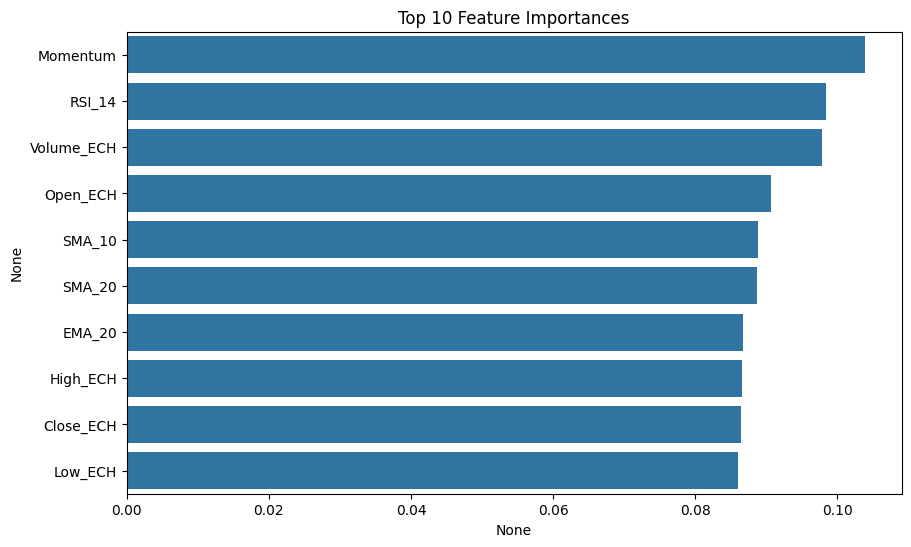

In [24]:
# Step 5: Feature Importance using Extra Trees
et_model = ExtraTreesClassifier(n_estimators=200, random_state=42)
et_model.fit(features_norm, target)
importances = pd.Series(et_model.feature_importances_, index=features_norm.columns)
importances.sort_values(ascending=False, inplace=True)

# Plot Top 10 Features
plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Feature Importances")
plt.show()

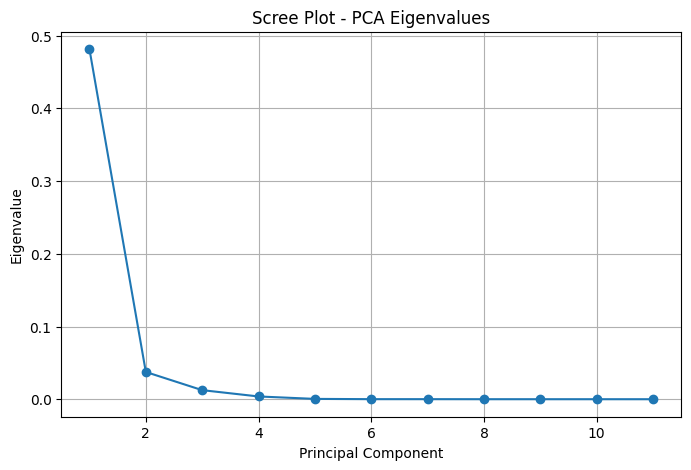

In [25]:
# Step 6: PCA (Optional Dimensionality Reduction)
pca = PCA()
pca.fit(features_norm)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o', linestyle='-')
plt.title("Scree Plot - PCA Eigenvalues")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

In [26]:
# Step 7: k-Fold Cross-Validation with MLP Neural Network
X = features_norm.values
y = target.values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = MLPClassifier(hidden_layer_sizes=(50,25), activation='relu', max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

print(f"Cross-Validation Accuracies: {accuracies}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")


Cross-Validation Accuracies: [0.5139442231075697, 0.5278884462151394, 0.5239043824701195, 0.5039840637450199, 0.5258964143426295]
Average Accuracy: 0.5191


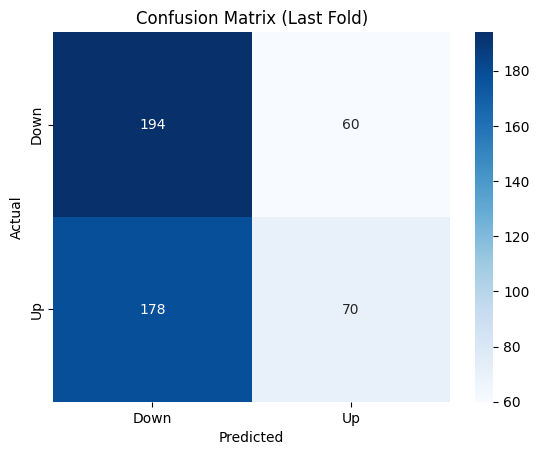

In [27]:
# Step 8: Confusion Matrix on Last Fold
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down','Up'], yticklabels=['Down','Up'])
plt.title("Confusion Matrix (Last Fold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


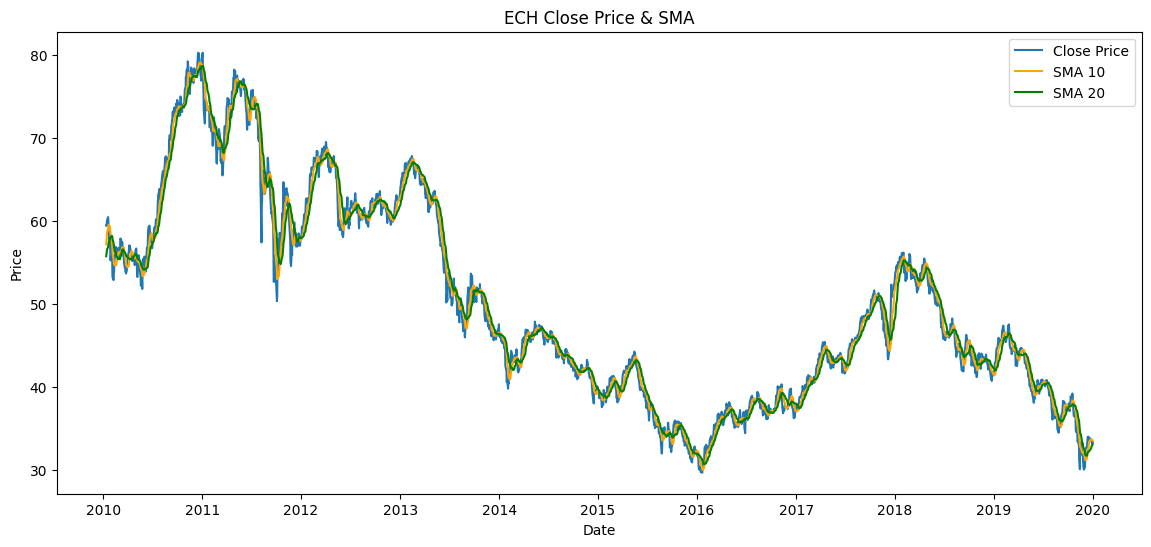

In [29]:
# Step 9: Plot Close Price and SMA
plt.figure(figsize=(14,6))
plt.plot(df['Close_ECH'], label='Close Price')
plt.plot(df['SMA_10'], label='SMA 10', color='orange')
plt.plot(df['SMA_20'], label='SMA 20', color='green')
plt.title(f"{tickers[0]} Close Price & SMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()